# Frequency scaling 

author: laquitainesteeve@gmail.com

Validation of frequency scaling for dense probes

A good fit of power law requires typically at least a range of frequency of 2 orders of magnitude, we high-pass filter with a cutoff of 100 Hz, and apply common referencing, then fit a power law to the power spectral density between 100 Hz and 10 KHz.

Execution time: 10 secs

Tested on Ubuntu 24.04.1 LTS (32 cores, 188 GB RAM, Intel(R) Core(TM) i9-14900K ＠3.2 GHz/5.8 GHz)

Resources required: 
- 180 GB RAM

## Setup

Prerequisites:

1. Setup "_envs/spikebias.yml_" virtual environment
2. Setup jupyter kernel _$python -m ipykernel install --user --name spikebias --display-name "spikebias"_
3. Download recordings: "_notebooks/0_download_recordings.ipynb_"
4. Pre-compute power spectral densities with: "_src/pipes/validation/psd/multiprocess.py_"

In [ ]:
# import libs
%load_ext autoreload
%autoreload 2

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.filterwarnings("ignore")

import os
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
import spikeinterface as si
import copy
import multiprocessing
import torch
import seaborn as sns
import pandas as pd
from scipy.stats import kruskal # stats
import scikit_posthocs as sp

# move to PROJECT PATH
PROJ_PATH = "/home/steeve/steeve/epfl/code/spikebias"
os.chdir(PROJ_PATH)

# import custom package
from src.nodes.validation import power

matplotlib.rcParams['agg.path.chunksize'] = 10000

# SETUP PARAMETERS
prm = dict()
prm["SFREQ_HV"] = 20000        # sampling frequency
prm["SFREQ_HS"] = 20000        # sampling frequency

# setup paths

# dense recordings
RAW_PATH_hv1 =  "dataset/00_raw/recording_horvath_probe1"
RAW_PATH_hv2 =  "dataset/00_raw/recording_horvath_probe2"
RAW_PATH_hv3 =  "dataset/00_raw/recording_horvath_probe3"
RAW_PATH_hs1 = "dataset/00_raw/recording_dense_probe1"
RAW_PATH_hs2 = "dataset/00_raw/recording_dense_probe2"
RAW_PATH_hs3 = "dataset/00_raw/recording_dense_probe3"

# power spectralddensities
PRE_PSD_PATH_HV1 = "dataset/01_intermediate/psds/psd_prep_horvath_probe1_cutoff_100.npy"
PRE_PSD_PATH_HV2 = "dataset/01_intermediate/psds/psd_prep_horvath_probe2_cutoff_100.npy"
PRE_PSD_PATH_HV3 = "dataset/01_intermediate/psds/psd_prep_horvath_probe3_cutoff_100.npy"
PRE_PSD_PATH_HS1 = "dataset/01_intermediate/psds/psd_prep_dense_probe1_cutoff_100.npy"
PRE_PSD_PATH_HS2 ="dataset/01_intermediate/psds/psd_prep_dense_probe2_cutoff_100.npy"
PRE_PSD_PATH_HS3 = "dataset/01_intermediate/psds/psd_prep_dense_probe3_cutoff_100.npy"

# pipeline parameters
SAVE_FIG = True
SAVE_TEMP_DATA = True
LOAD_TEMP_DATA = False

PLOT_DATA_PATH_DENSE = "dataset/02_figure_dataset/fig2u_data_fscaling_dense.parquet"

# FIGURE SETTINGS
FIG_SIZE = (1.5, 1.5)
# experiment colors
cl = dict()
cl["COLOR_MEDIAN"] = (1, 0.76, 0)
cl["COLOR_HV"] = "k" # black
cl["COLOR_HS"] = np.array([26, 152, 80]) / 255 # green

# axes aesthetics
plt.rcParams["font.family"] = "Arial"
plt.rcParams["font.size"] = 6  # 5-7 with Nature neuroscience as reference
plt.rcParams["lines.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.linewidth"] = 0.5 # typically 0.5 - 1 pt
plt.rcParams["axes.spines.top"] = False
plt.rcParams["xtick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.major.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["ytick.minor.width"] = 0.5 #0.8 #* 1.3
plt.rcParams["xtick.major.size"] = 3.5 * 1.1
plt.rcParams["xtick.minor.size"] = 2 * 1.1
plt.rcParams["ytick.major.size"] = 3.5 * 1.1
plt.rcParams["ytick.minor.size"] = 2 * 1.1
N_MAJOR_TICKS = 4
N_MINOR_TICKS = 12
savefig_cfg = {"transparent":True, "dpi":300}
legend_cfg = {"frameon": False, "handletextpad": 0.1}
tight_layout_cfg = {"pad": 0.5}
LG_FRAMEON = False              # no legend frame


# parameterize
FIG_SIZE = (1, 1)
pm = {
    "linestyle": "None",
    "marker": "o",
    "markersize": 1.5,
    "rasterized": True,
    "markeredgecolor": "w",
    "markeredgewidth": 0.06,
}
pm_fit1 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}
pm_fit2 = {
    "linestyle": "-",
    "linewidth": 0.5,
    "color": "k",
}

### Specs

In [2]:
# cpus, gpu and current memory usage
print("available cpus:", multiprocessing.cpu_count())
print("available gpus:", torch.cuda.is_available())
%system free -m

available cpus: 32
available gpus: True


['               total        used        free      shared  buff/cache   available',
 'Mem:          192987       16361      174441         160        4077      176626',
 'Swap:           8191        5505        2686']

### Custom functions

In [3]:
def print_slope(alpha):
    print(f"\u03B1={np.round(np.mean(alpha),1)}\u00B1{np.round(np.std(alpha),1)}")


def get_slope_df(data: list, exp, layer):
    df = pd.DataFrame()
    df["Alpha"] = np.negative(data)
    df["Experiment"] = exp
    df["Layer"] = layer
    return df

### (1s)Load dataset

* select first 10 min for speed

In [4]:
# Load traces
RawHV1 = si.load_extractor(RAW_PATH_hv1)
RawHS1 = si.load_extractor(RAW_PATH_hs1)
RawHV2 = si.load_extractor(RAW_PATH_hv2)
RawHS2 = si.load_extractor(RAW_PATH_hs2)
RawHV3 = si.load_extractor(RAW_PATH_hv3)
RawHS3 = si.load_extractor(RAW_PATH_hs3)

# 4 - get good sites (in cortex) **********************
lyrs = ["L1", "L2_3", "L4", "L5", "L6"]
# simulated dense recording
site_ly_hs1 = RawHS1.get_property("layers")
site_ly_hs1 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs1])
sites_hs1 = np.where(np.isin(site_ly_hs1, ["L1", "L2_3"]))[0]
site_ly_hs2 = RawHS2.get_property("layers")
sites_hs2 = np.where(np.isin(site_ly_hs2, ["L4", "L5"]))[0]
site_ly_hs3 = RawHS3.get_property("layers")
site_ly_hs3 = np.array(["L2_3" if x == "L2" or x == "L3" else x for x in site_ly_hs3])
sites_hs3 = np.where(np.isin(site_ly_hs3, ["L6"]))[0]

# horvath recording
site_ly_hv1 = RawHV1.get_property("layers")
sites_hv1 = np.where(np.isin(site_ly_hv1, ["L1", "L2_3"]))[0]
site_ly_hv2 = RawHV2.get_property("layers")
sites_hv2 = np.where(np.isin(site_ly_hv2, ["L4", "L5"]))[0]
site_ly_hv3 = RawHV3.get_property("layers")
sites_hv3 = np.where(np.isin(site_ly_hv3, ["L6"]))[0]

# Load pre-computed PSDs
psd_pre_hv1 = np.load(PRE_PSD_PATH_HV1, allow_pickle=True).item()
psd_pre_hv2 = np.load(PRE_PSD_PATH_HV2, allow_pickle=True).item()
psd_pre_hv3 = np.load(PRE_PSD_PATH_HV3, allow_pickle=True).item()
psd_pre_hs1 = np.load(PRE_PSD_PATH_HS1, allow_pickle=True).item()
psd_pre_hs2 = np.load(PRE_PSD_PATH_HS2, allow_pickle=True).item()
psd_pre_hs3 = np.load(PRE_PSD_PATH_HS3, allow_pickle=True).item()

# unit-test power spectral density resolutions
assert psd_pre_hv1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hv3["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs1["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs2["freq"][1] == 1.0, "psd resolution should be 1Hz"
assert psd_pre_hs3["freq"][1] == 1.0, "psd resolution should be 1Hz"

# All Layers


LFP band
α=0.1±0.3
α=0.5±0.2

Spiking band
α=-1.4±0.3
α=-0.2±0.2


n=272 sites
n=297 sites

Power SNR
SNR: 4.325060844421387
SNR: 32.055267333984375


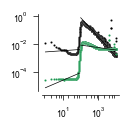

In [7]:
# horvath vivo (all layers)
# L1 (probe 1)
psd_pre_hv1_L1 = copy.copy(psd_pre_hv1)
psd_pre_hv1_L1["power"] = psd_pre_hv1["power"][site_ly_hv1[sites_hv1] == "L1", :]
# L23 (probe 1)
psd_pre_hv1_L23 = copy.copy(psd_pre_hv1)
psd_pre_hv1_L23["power"] = psd_pre_hv1["power"][site_ly_hv1[sites_hv1] == "L2_3", :]
# L4 (probe 2)
psd_pre_hv2_L4 = copy.copy(psd_pre_hv2)
psd_pre_hv2_L4["power"] = psd_pre_hv2["power"][site_ly_hv2[sites_hv2] == "L4", :]
# L5 (probe 2)
psd_pre_hv2_L5 = copy.copy(psd_pre_hv2)
psd_pre_hv2_L5["power"] = psd_pre_hv2["power"][site_ly_hv2[sites_hv2] == "L5", :]
# L6 (probe 3)
psd_pre_hv3_L6 = copy.copy(psd_pre_hv3)
psd_pre_hv3_L6["power"] = psd_pre_hv3["power"][site_ly_hv3[sites_hv3] == "L6", :]

# sites in target layers in each probe
psd_all_hv = dict()
psd_all_hv["power"] = np.vstack(
    [
        psd_pre_hv1_L1["power"],
        psd_pre_hv1_L23["power"],
        psd_pre_hv2_L4["power"],
        psd_pre_hv2_L5["power"],
        psd_pre_hv3_L6["power"],
    ]
)
psd_all_hv["freq"] = psd_pre_hv1["freq"]


# horvath biophy. spont. (all layers) **************************
# L1 (probe 1)
psd_pre_hs1_L1 = copy.copy(psd_pre_hs1)
psd_pre_hs1_L1["power"] = psd_pre_hs1["power"][site_ly_hs1[sites_hs1] == "L1", :]
# L23 (probe 1)
psd_pre_hs1_L23 = copy.copy(psd_pre_hs1)
psd_pre_hs1_L23["power"] = psd_pre_hs1["power"][site_ly_hs1[sites_hs1] == "L2_3", :]
# L4 (probe 2)
psd_pre_hs2_L4 = copy.copy(psd_pre_hs2)
psd_pre_hs2_L4["power"] = psd_pre_hs2["power"][site_ly_hs2[sites_hs2] == "L4", :]
# L5 (probe 2)
psd_pre_hs2_L5 = copy.copy(psd_pre_hs2)
psd_pre_hs2_L5["power"] = psd_pre_hs2["power"][site_ly_hs2[sites_hs2] == "L5", :]
# L6 (probe 3)
psd_pre_hs3_L6 = copy.copy(psd_pre_hs3)
psd_pre_hs3_L6["power"] = psd_pre_hs3["power"][site_ly_hs3[sites_hs3] == "L6", :]

# sites in target layers in each probe
psd_all_hs = dict()
psd_all_hs["power"] = np.vstack(
    [
        psd_pre_hs1_L1["power"],
        psd_pre_hs1_L23["power"],
        psd_pre_hs2_L4["power"],
        psd_pre_hs2_L5["power"],
        psd_pre_hs3_L6["power"],
    ]
)
psd_all_hs["freq"] = psd_pre_hs1["freq"]


FIG_SIZE = (1, 1)

# we rasterize, else dots increase file size by
# 6MB per plot
# takes 2 mins
YLIM_AX1 = [0, 0.02]
YLIM_AX2 = [0, 0.08]
N_MAJOR_TICKS = 4
ALPHA = 0.7
fig, ax1 = plt.subplots(1, 1, figsize=FIG_SIZE)

# Fit panel ************************************************************

ax1, alphas_lfp_hv, alphas_spiking_hv = power.plot_fits_all(
    ax1, psd_all_hv, prm["SFREQ_HV"], cl["COLOR_HV"], pm, pm_fit1, pm_fit2, lfp_band=(0, 90), spiking_band=(100, 10000)
)
ax1, alphas_lfp_hs, alphas_spiking_hs = power.plot_fits_all(
    ax1, psd_all_hs, prm["SFREQ_HS"], cl["COLOR_HS"], pm, pm_fit1, pm_fit2, lfp_band=(0, 90), spiking_band=(100, 10000)
)

# axes legend
# esthetics
ax1.set_xscale("log")
ax1.set_yscale("log")
ax1.spines[["top", "right"]].set_visible(False)
# minor ticks
locmaj = matplotlib.ticker.LogLocator(base=10, numticks=N_MAJOR_TICKS)
locmin = matplotlib.ticker.LogLocator(
    base=10.0,
    subs=(0.2, 0.4, 0.6, 0.8),
    numticks=N_MINOR_TICKS,
)
ax1.tick_params(which="both")
ax1.xaxis.set_major_locator(locmaj)
ax1.xaxis.set_minor_locator(locmin)
ax1.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# disconnect axes (R style)
ax1.spines["bottom"].set_position(("axes", -0.05))
ax1.yaxis.set_ticks_position("left")
ax1.spines["left"].set_position(("axes", -0.05))

# report slopes
# lfp band
print("\nLFP band")
print_slope(alphas_lfp_hv)
print_slope(alphas_lfp_hs)

# spiking band
print("\nSpiking band")
print_slope(alphas_spiking_hv)
print_slope(alphas_spiking_hs)

# print sites
print("\n")
print(f"""n={psd_all_hv["power"].shape[0]} sites""")
print(f"""n={psd_all_hs["power"].shape[0]} sites""")


# SNR **************************
print("\nPower SNR")

out_hv = power.get_power_snr(psd_all_hv["power"], psd_all_hv["freq"], 100, 10000, 80)
out_hs = power.get_power_snr(psd_all_hs["power"], psd_all_hs["freq"], 100, 10000, 90)

# # save
# if SAVE_FIG:
#     plt.savefig(
#         "figures/6_supp/fig2/fig2G_pre_power_fit_all_sites.svg",
#         **savefig_cfg,
#     )

## Compute layer-wise data

In [10]:
%%time 

d1 = power.get_psd_data_prepro_dense(
    "L1",
    psd_pre_hv1,
    psd_pre_hs1,
    site_ly_hv1[sites_hv1],
    site_ly_hs1[sites_hs1],
)

d23 = power.get_psd_data_prepro_dense(
    "L2_3",
    psd_pre_hv1,
    psd_pre_hs1,
    site_ly_hv1[sites_hv1],
    site_ly_hs1[sites_hs1],
)

d4 = power.get_psd_data_prepro_dense(
    "L4",
    psd_pre_hv2,  # probe 2
    psd_pre_hs2,
    site_ly_hv2[sites_hv2],  # probe 2
    site_ly_hs2[sites_hs2],
)
d5 = power.get_psd_data_prepro_dense_layer_5(
    "L5",
    psd_pre_hv2,  # probe 2
    psd_pre_hs2,
    site_ly_hv2[sites_hv2],  # probe 2
    site_ly_hs2[sites_hs2],
)

d6 = power.get_psd_data_prepro_dense(
    "L6",
    psd_pre_hv3,  # probe 3
    psd_pre_hs3,
    site_ly_hv3[sites_hv3],  # probe 3
    site_ly_hs3[sites_hs3],
)

CPU times: user 34.1 ms, sys: 0 ns, total: 34.1 ms
Wall time: 33.6 ms


## Power law fits


LFP band
hv: α=0.3±0.1
hs: α=0.5±0.0

Spiking band
hv: α=-1.0±0.1
hs: α=-0.1±0.0

LFP band
hv: α=0.5±0.1
hs: α=0.5±0.1

Spiking band
hv: α=-1.4±0.2
hs: α=-0.1±0.1

LFP band
hv: α=-0.1±0.0
hs: α=0.5±0.1

Spiking band
hv: α=-1.5±0.1
hs: α=-0.2±0.1

LFP band
α=-0.2±0.1
α=0.5±0.1

Spiking band
α=-1.5±0.2
α=-0.2±0.1

Power SNR
SNR: 2.2521305084228516
SNR: 43.673789978027344

LFP band
hv: α=-0.0±0.2
hs: α=0.6±0.2

Spiking band
hv: α=-1.3±0.2
hs: α=-0.3±0.3


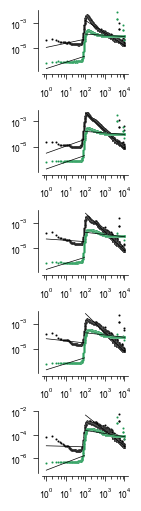

In [12]:
# cutoff 100 Hz
FIG_SIZE = (1.3, 5)

fig, axes = plt.subplots(5, 1, figsize=FIG_SIZE)

# L1
axes[0], dd1 = power.plot_power_law_fits_dense(axes[0], d1, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000))
# L2/3
axes[1], dd23 = power.plot_power_law_fits_dense(axes[1], d23, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000))
# L4
axes[2], dd4 = power.plot_power_law_fits_dense(axes[2], d4, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000))
# L5
axes[3], dd5 = power.plot_power_law_fits_dense_layer_5(
    axes[3], d5, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000)
)
# L6
axes[4], dd6 = power.plot_power_law_fits_dense(axes[4], d6, prm, cl, pm, pm_fit1, pm_fit2, lfp_band=(0,90), spiking_band=(100,10000))

fig.tight_layout(**tight_layout_cfg)

# # save
# if SAVE_FIG:
#     plt.savefig("figures/0_validation/4_power/fig2R/fig2R_pre_power_fit.svg", **savefig_cfg)

## Frequency scaling in spiking band

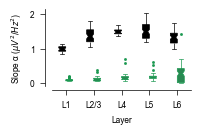

In [25]:
FIG_SIZE = (1.8, 1)

# layer 1
# neuropixels
df1 = get_slope_df(dd1["alphas_spiking_hv"], "H", "L1")
df2 = get_slope_df(dd1["alphas_spiking_hs"], "DS", "L1")

# layer 2/3
df3 = get_slope_df(dd23["alphas_spiking_hv"], "H", "L2/3")
df4 = get_slope_df(dd23["alphas_spiking_hs"], "DS", "L2/3")

# layer 4
df5 = get_slope_df(dd4["alphas_spiking_hv"], "H", "L4")
df6 = get_slope_df(dd4["alphas_spiking_hs"], "DS", "L4")

# layer 5
df7 = get_slope_df(dd5["alphas_spiking_hv"], "H", "L5")
df8 = get_slope_df(dd5["alphas_spiking_hs"], "DS", "L5")

# layer 6
df9 = get_slope_df(dd6["alphas_spiking_hv"], "H", "L6")
df10 = get_slope_df(dd6["alphas_spiking_hs"], "DS", "L6")

plot_df_dense = pd.concat([df1, df2, df3, df4, df5, df6, df7, df8, df9, df10])

fig, ax = plt.subplots(1, 1, figsize=FIG_SIZE)

# plot spiking band scaling
ax = sns.boxplot(
    ax=ax,
    data=plot_df_dense,
    x="Layer",
    y="Alpha",
    hue="Experiment",
    notch=True,
    hue_order=[
        "H",
        "DS",
    ],
    palette=[
        cl["COLOR_HV"],
        cl["COLOR_HS"],
    ],
    width=0.5,
    linewidth=0.5,
    flierprops={
        "marker": ".",
        "markersize": 3,
        "markerfacecolor": "w",
        "markeredgecolor": (0.6, 0.6, 0.6),
        "markeredgewidth": 0.5,
    },
)

# axes
ax.spines[["top", "right"]].set_visible(False)
ax.legend("", frameon=False)

# disconnect axes (R style)
ax.spines["bottom"].set_position(("axes", -0.05))
ax.yaxis.set_ticks_position("left")
ax.spines["left"].set_position(("axes", -0.05))
ax.set_ylabel("Slope \u03B1 ($\u03bcV^2 /Hz^2$)")

#ax.set_ylim([0, 2])

# customize the boxplot
p = 0
for box in ax.patches:
    if box.__class__.__name__ == "PathPatch":
        # a list item for each layer group
        if p in [0, 1, 2, 3, 4]:
            # Each box has 6 associated Line2D objects
            # (to make the whiskers, fliers, etc.)
            # Loop over them here, and use the same colour
            # as above
            # group 1 (NV)
            box.set_edgecolor(cl["COLOR_HV"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HV"])  # box
                ax.lines[k].set_mfc(cl["COLOR_HV"])  # whisker
                ax.lines[k].set_mec(cl["COLOR_HV"])  # fliers
            p += 1
        elif p in [5, 6, 7, 8, 9]:
            # group 2 (DS)
            box.set_edgecolor(cl["COLOR_HS"])
            for k in range(6 * p, 6 * (p + 1)):
                ax.lines[k].set_color(cl["COLOR_HS"])
                ax.lines[k].set_mfc(cl["COLOR_HS"])
                ax.lines[k].set_mec(cl["COLOR_HS"])
            p += 1

# save
if SAVE_FIG: plt.savefig("figures/0_validation/4_power/fig2V/fig2V_fscaling_spiking_dense.svg", **savefig_cfg)

## Save TEMP data

In [4]:
# save plot and statistics data
if SAVE_TEMP_DATA:
    plot_df_dense.to_parquet(PLOT_DATA_PATH_DENSE)
    print("Saved here:", PLOT_DATA_PATH_DENSE)
elif LOAD_TEMP_DATA:
    plot_df_dense = pd.read_parquet(PLOT_DATA_PATH_DENSE)

### Hypothesis testing

In [14]:
def get_slope(df, exp, layer):
    return df[(df.Experiment == exp) & (df.Layer == layer)]["Alpha"].values


def get_kk(df, exp):
    """kruskall wallis test"""
    h, p = kruskal(
        get_slope(df, exp, "L1"),
        get_slope(df, exp, "L2/3"),
        get_slope(df, exp, "L4"),
        get_slope(df, exp, "L5"),
        get_slope(df, exp, "L6"),
    )

    print(f"H={h}, p={p}")
    print(f"""N_L1 = {len(get_slope(df, exp, "L1"))} sites""")
    print(f"""N_L23 = {len(get_slope(df, exp, "L2/3"))} sites""")
    print(f"""N_L4 = {len(get_slope(df, exp, "L4"))} sites""")
    print(f"""N_L5 = {len(get_slope(df, exp, "L5"))} sites""")
    print(f"""N_L6 = {len(get_slope(df, exp, "L6"))} sites""")


def get_posthoc_dunn_holm_sidak(df, exp):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        df (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_slope(df, exp, "L1"),
        get_slope(df, exp, "L2/3"),
        get_slope(df, exp, "L4"),
        get_slope(df, exp, "L5"),
        get_slope(df, exp, "L6"),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["L1", "L2/3", "L4", "L5", "L6"]
    df.index = ["L1", "L2/3", "L4", "L5", "L6"]
    return df


def ci95(data):
    return 1.96 * np.nanstd(data) / np.sqrt(np.sum(~np.isnan(data)))

def get_medians_and_ci95(plot_data, exp, feature: str):
    layers = ["L1", "L2/3", "L4", "L5", "L6"]
    stats = ""
    record = []
    for layer in layers:
        feature_data = plot_data[(plot_data.Experiment==exp) & (plot_data.Layer==layer)][feature]
        stats += f"{np.round(feature_data.median()*10000)/10000} $\pm$ {np.round(ci95(feature_data),6)}, "
        record.append(np.round(feature_data.median()*10000)/10000)
    print(stats)
    return record

### Slope changes across layers?

NPX

DENSE

In [26]:
print("\n--------------------H--------------------\n")
get_kk(plot_df_dense, "H")
get_posthoc_dunn_holm_sidak(plot_df_dense, "H")
m_h = get_medians_and_ci95(plot_df_dense, "H", "Alpha") 

print("\n--------------------DS--------------------\n")
get_kk(plot_df_dense, "DS")
get_posthoc_dunn_holm_sidak(plot_df_dense, "DS")
m_ds = get_medians_and_ci95(plot_df_dense, "DS", "Alpha") 


--------------------H--------------------

H=114.37606774233075, p=8.479810396932695e-24
N_L1 = 36 sites
N_L23 = 60 sites
N_L4 = 20 sites
N_L5 = 88 sites
N_L6 = 68 sites
0.9871 $\pm$ 0.024907, 1.3571 $\pm$ 0.052758, 1.4833 $\pm$ 0.03579, 1.4916 $\pm$ 0.049006, 1.3283 $\pm$ 0.045897, 

--------------------DS--------------------

H=44.81977808347085, p=4.334192580401397e-09
N_L1 = 37 sites
N_L23 = 64 sites
N_L4 = 32 sites
N_L5 = 88 sites
N_L6 = 76 sites
0.0832 $\pm$ 0.013474, 0.1059 $\pm$ 0.01485, 0.134 $\pm$ 0.045931, 0.1674 $\pm$ 0.016748, 0.2782 $\pm$ 0.057014, 


## Are models and in vivo data the same?

In [27]:
from scipy.stats import kruskal
import scikit_posthocs as sp


def count_sites(df, exp, layer):
    return len(df[(df["Experiment"] == exp) & (df["Layer"] == layer)])


def get_alpha(df, exp, layer):
    return df[(df["Experiment"] == exp) & (df["Layer"] == layer)]["Alpha"].values


def get_kk_compare_exps(df, layer):
    """kruskall wallis test
    """
    h, p = kruskal(
        get_alpha(df, "H", layer),
        get_alpha(df, "DS", layer),
    )
    print(f"H={h}, p={p}")
    print(f"""N_H = {count_sites(df, "H", layer)} sites""")
    print(f"""N_DS = {count_sites(df, "DS", layer)} sites""")
    
    
def get_posthoc_dunn_holm_sidak_compare_exps(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_alpha(plot_data, "H", layer),
        get_alpha(plot_data, "DS", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["H", "DS"]
    df.index = ["H", "DS"]
    return df

def get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_data, layer):
    """posthoc test after kruskall wallis with Dunn and holm_sidak
    multiple comparison correction of p-values

    Args:
        plot_data (_type_): _description_
        exp (_type_): _description_

    Returns:
        _type_: _description_
    """
    data = [
        get_alpha(plot_data, "H", layer),
        get_alpha(plot_data, "DS", layer),
    ]
    # holm sidak method has more power than Bonferroni which is more conservative
    # Non-significance can indicate subtle differences, power issues, samll sample size,
    # or the balancing be due to how the Holm-Sidak correction controls Type I errors
    # while retaining power.
    # we can still look at the p-values to identify trends.
    df = sp.posthoc_dunn(data, p_adjust="holm-sidak")
    df.columns = ["H", "DS"]
    df.index = ["H", "DS"]
    return df

In [19]:
print("------LAYER 1:------\n")

# kruskall-wallis
# perform Dunn's posthoc test using a holm-sidak correction for the p-values
# to identify the layer amplitudes that significantly deviate from others
get_kk_compare_exps(plot_df_dense, "L1")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_dense, "L1"))


print("\n------LAYER 2/3:------\n")

get_kk_compare_exps(plot_df_dense, "L2/3")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_dense, "L2/3"))

print("\n------LAYER 4:------\n")

get_kk_compare_exps(plot_df_dense, "L4")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_dense, "L4"))

print("\n------LAYER 5:------\n")

get_kk_compare_exps(plot_df_dense, "L5")
display(get_posthoc_dunn_holm_sidak_compare_exps_l5(plot_df_dense, "L5"))

print("\n------LAYER 6:------\n")

get_kk_compare_exps(plot_df_dense, "L6")
display(get_posthoc_dunn_holm_sidak_compare_exps(plot_df_dense, "L6"))

------LAYER 1:------

H=54.0, p=2.0048960802803017e-13
N_H = 36 sites
N_DS = 37 sites


,H,DS
H,1.000000e+00,2.004896e-13
DS,2.004896e-13,1.000000e+00



------LAYER 2/3:------

H=92.15999999999997, p=7.994442411452592e-22
N_H = 60 sites
N_DS = 64 sites


,H,DS
H,1.000000e+00,7.994442e-22
DS,7.994442e-22,1.000000e+00



------LAYER 4:------

H=36.226415094339615, p=1.7567319179177604e-09
N_H = 20 sites
N_DS = 32 sites


,H,DS
H,1.000000e+00,1.756732e-09
DS,1.756732e-09,1.000000e+00



------LAYER 5:------

H=131.25423728813564, p=2.1784112745805386e-30
N_H = 88 sites
N_DS = 88 sites


,H,DS
H,1.000000e+00,2.178411e-30
DS,2.178411e-30,1.000000e+00



------LAYER 6:------

H=102.8262410590371, p=3.6587104204369764e-24
N_H = 68 sites
N_DS = 76 sites


,H,DS
H,1.000000e+00,3.658710e-24
DS,3.658710e-24,1.000000e+00


## Summary statistics

In [21]:
def pc(x1, x2):
    return (x1-x2)/x1 * 100

In [ ]:
# DENSE average  ------------------

L1 = pc(m_h=[0], m_ds[0])

L23 = pc(m_h[1], m_ds[1])

L4 = pc(m_h[2], m_ds[2])

L5 = pc(m_h[3], m_ds[3])

L6 = pc(m_h[4], m_ds[4])

print("\nDENSE :Models median power are on average ", - np.round(np.median([L1, L23, L4, L5, L6]),1), "% than Horvath data")


DENSE :Models median power are on average  -91.0 % than Horvath data


# References

see plot of known frequency scaling properties of LFP (http://www.scholarpedia.org/article/File:Diffusion-LFP.jpg)
